In [1]:
!pip install pytorch_ranger

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [3]:
os.listdir('../input/cassava-leaf-disease-classification/')

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [4]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
test = pd.read_csv('../input/cassava-leaf-disease-classification//sample_submission.csv')
label_map = pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', orient='index')

display(train.head())
display(test.head())
display(label_map)

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

image_id  label
0  2216849948.jpg      4

0
0       Cassava Bacterial Blight (CBB)
1  Cassava Brown Streak Disease (CBSD)
2           Cassava Green Mottle (CGM)
3         Cassava Mosaic Disease (CMD)
4                              Healthy

## Directory settings

In [5]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = '../input/cassava-leaf-disease-classification/train_images'
TEST_PATH = '../input/cassava-leaf-disease-classification/test_images'

## CFG

In [6]:
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = 'resnext50_32x4d'
    size = 256
    scheduler = 'CosineAnnealingWarmRestarts'
    epochs = 10
    T_0 = 10
    lr = 1e-4
    min_lr = 1e-6
    batch_size = 32
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    seed = 42
    target_size = 5
    target_col = 'label'
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True
    inference = False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## Library

In [7]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

sys.path.append('../input/pytorch-optimizer')
import torch_optimizer as optim

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [8]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f}')
    
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


## Dataset

In [10]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

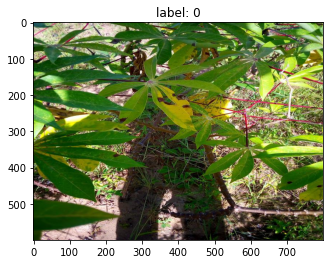

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show()

## Transforms

In [12]:
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG.size, CFG.size), 
            Transpose(p=0.5), 
            HorizontalFlip(p=0.5), 
            VerticalFlip(p=0.5), 
            ShiftScaleRotate(p=0.5), 
            Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
            ), 
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size), 
            Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
            ), 
            ToTensorV2(),
        ])

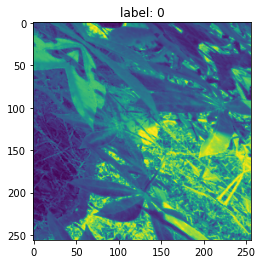

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

## MODEL

In [14]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
model = CustomResNext(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, 
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    print(image.size())
    output = model(image)
    print(output)
    break

torch.Size([4, 3, 256, 256])
tensor([[ 0.1379, -0.0437,  0.0715,  0.2726, -0.0931],
        [ 0.1407,  0.1553,  0.0661,  0.6412,  0.1147],
        [ 0.1008, -0.0071,  0.0307,  0.3932, -0.0678],
        [ 0.1247,  0.0810,  0.0957,  0.5489,  0.1670]],
       grad_fn=<AddmmBackward>)


In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    """秒を分に変換する関数"""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """経過時間の測定と終了時間の予測を行う関数
    Parameters
    ----------
    since : float
        実験を始めた時刻
    percent : float
        実験が進んだ割合
        
    Returns
    -------
    s : 経過時間
    re : 終了までの時間の予測
    """
    now = time.time()
    s = now - since  # 経過時間の測定
    es = s / percent  # 終了時間の予測
    re = es - s  # 残り時間の予想
    return '%s (remain %s)' % (asMinutes(s), asMinutes(re))

def train_fn(train_loader, model, criterion, optimizer, epoch, shechduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else: 
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}]'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})'
                  'Elapsed {remain:s}' 
                  'Loss: {loss.val:.4f}({loss.avg:.4f})' 
                  'Grad: {grad_norm:.4f}  '
                  .format(epoch+1, step, len(train_loader), batch_time=batch_time, 
                          data_time=data_time, loss=losses, 
                          remain=timeSince(start, float(step+1)/len(train_loader)), 
                          grad_norm=grad_norm))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
            
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avgpreds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

## Train loop

In [17]:
# ======================================================
# Train loop
# ======================================================

def train_loop(folds, fold):
    
    LOGGER.info(f'========== fold: {fold} training ============')
    
    # ======================================================
    # loader
    # ======================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, 
                              pin_memory=True, 
                              drop_last=False)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, 
                              pin_memory=True, 
                              drop_last=False)
    
    # ===============================================
    # scheduler
    # ===============================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler
    
    # ===============================================
    # model & optimizer
    # ===============================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)
    
    optimizer = optim.AdaBelief(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
#     optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    # ===============================================
    # apex 
    # ===============================================
    if CFG.apex:
        model.optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)
        
    # ===============================================
    # loop
    # ===============================================
    criterion = nn.CrossEntropyLoss()
    
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        
        # scoring
        score = get_score(valid_labels, preds.argmax(1))
        
        elapsed = time.time() - start_time
        
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f} avg_val_loss: {avg_val_loss:.4f} time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)
    
    return valid_folds

In [18]:
# ====================================================
# main
# ====================================================
def main():
    
    """
    Prepare: 1.train 2.test 3.submission 4.folds
    """
    
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
        
    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f'=============== fold: {fold} result ================')
                get_result(_oof_df)
        # CV result
        LOGGER.info(f'============ CV ============')
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        
    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, batch_size=CFG.batch_size, shuffle=False, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [19]:
if __name__ == '__main__':
    main()

========== fold: 0 training ============
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth


Epoch: [1][0/535]Data 1.534 (1.534)Elapsed 0m 3s (remain 29m 44s)Loss: 1.5510(1.5510)Grad: 8.2122  
Epoch: [1][100/535]Data 0.000 (0.016)Elapsed 0m 42s (remain 3m 3s)Loss: 0.7697(0.9443)Grad: 9.3608  
Epoch: [1][200/535]Data 0.000 (0.008)Elapsed 1m 23s (remain 2m 18s)Loss: 0.3441(0.8017)Grad: 5.0453  
Epoch: [1][300/535]Data 0.004 (0.006)Elapsed 2m 4s (remain 1m 36s)Loss: 0.4582(0.7314)Grad: 7.9780  
Epoch: [1][400/535]Data 0.000 (0.004)Elapsed 2m 45s (remain 0m 55s)Loss: 0.4888(0.6860)Grad: 6.6764  
Epoch: [1][500/535]Data 0.000 (0.004)Elapsed 3m 25s (remain 0m 13s)Loss: 0.4212(0.6560)Grad: 9.2764  
Epoch: [1][534/535]Data 0.000 (0.003)Elapsed 3m 39s (remain 0m 0s)Loss: 0.5786(0.6503)Grad: 7.0115  
EVAL: [0/134] Data 1.538 (1.538) Elapsed 0m 1s (remain 3m 38s) Loss: 0.6209(0.6209) 
EVAL: [100/134] Data 0.706 (0.205) Elapsed 0m 30s (remain 0m 9s) Loss: 0.5761(0.4996) 


Epoch 1 - avg_train_loss: 0.6503 avg_val_loss: 0.4983 time: 258s
Epoch 1 - Accuracy: 0.8301401869158879
Epoch 1 - Save Best Score: 0.8301 Model


EVAL: [133/134] Data 0.000 (0.194) Elapsed 0m 38s (remain 0m 0s) Loss: 0.6900(0.4983) 
Epoch: [2][0/535]Data 1.159 (1.159)Elapsed 0m 1s (remain 14m 9s)Loss: 0.6030(0.6030)Grad: 9.3552  
Epoch: [2][100/535]Data 0.000 (0.012)Elapsed 0m 41s (remain 2m 57s)Loss: 0.2495(0.4883)Grad: 5.6045  
Epoch: [2][200/535]Data 0.000 (0.006)Elapsed 1m 19s (remain 2m 12s)Loss: 0.5938(0.4904)Grad: 9.7870  
Epoch: [2][300/535]Data 0.000 (0.004)Elapsed 1m 59s (remain 1m 32s)Loss: 0.5032(0.4802)Grad: 7.0368  
Epoch: [2][400/535]Data 0.000 (0.003)Elapsed 2m 37s (remain 0m 52s)Loss: 0.4394(0.4806)Grad: 6.3004  
Epoch: [2][500/535]Data 0.004 (0.003)Elapsed 3m 15s (remain 0m 13s)Loss: 0.5443(0.4857)Grad: 7.4457  
Epoch: [2][534/535]Data 0.000 (0.003)Elapsed 3m 28s (remain 0m 0s)Loss: 0.6821(0.4830)Grad: 9.3569  
EVAL: [0/134] Data 1.159 (1.159) Elapsed 0m 1s (remain 2m 46s) Loss: 0.6237(0.6237) 
EVAL: [100/134] Data 0.616 (0.182) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4596(0.4434) 


Epoch 2 - avg_train_loss: 0.4830 avg_val_loss: 0.4434 time: 245s
Epoch 2 - Accuracy: 0.8504672897196262
Epoch 2 - Save Best Score: 0.8505 Model


EVAL: [133/134] Data 0.000 (0.174) Elapsed 0m 36s (remain 0m 0s) Loss: 0.7808(0.4434) 
Epoch: [3][0/535]Data 1.230 (1.230)Elapsed 0m 1s (remain 14m 56s)Loss: 0.2225(0.2225)Grad: 4.1102  
Epoch: [3][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 56s)Loss: 0.4742(0.4304)Grad: 6.3389  
Epoch: [3][200/535]Data 0.000 (0.007)Elapsed 1m 19s (remain 2m 11s)Loss: 0.4080(0.4446)Grad: 5.8582  
Epoch: [3][300/535]Data 0.000 (0.005)Elapsed 1m 58s (remain 1m 32s)Loss: 0.3556(0.4568)Grad: 4.7537  
Epoch: [3][400/535]Data 0.000 (0.003)Elapsed 2m 37s (remain 0m 52s)Loss: 0.3291(0.4514)Grad: 7.4331  
Epoch: [3][500/535]Data 0.000 (0.003)Elapsed 3m 16s (remain 0m 13s)Loss: 0.4212(0.4494)Grad: 7.2536  
Epoch: [3][534/535]Data 0.000 (0.003)Elapsed 3m 29s (remain 0m 0s)Loss: 0.4855(0.4490)Grad: 6.8828  
EVAL: [0/134] Data 0.954 (0.954) Elapsed 0m 1s (remain 2m 19s) Loss: 0.5929(0.5929) 
EVAL: [100/134] Data 0.353 (0.174) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4968(0.4283) 


Epoch 3 - avg_train_loss: 0.4490 avg_val_loss: 0.4271 time: 244s
Epoch 3 - Accuracy: 0.8551401869158879
Epoch 3 - Save Best Score: 0.8551 Model


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 34s (remain 0m 0s) Loss: 0.8098(0.4271) 
Epoch: [4][0/535]Data 1.498 (1.498)Elapsed 0m 1s (remain 17m 22s)Loss: 0.5614(0.5614)Grad: 6.6537  
Epoch: [4][100/535]Data 0.000 (0.015)Elapsed 0m 41s (remain 2m 56s)Loss: 0.4740(0.4204)Grad: 7.1665  
Epoch: [4][200/535]Data 0.000 (0.008)Elapsed 1m 19s (remain 2m 12s)Loss: 0.6707(0.4325)Grad: 9.2623  
Epoch: [4][300/535]Data 0.000 (0.006)Elapsed 1m 58s (remain 1m 32s)Loss: 0.3095(0.4299)Grad: 7.4404  
Epoch: [4][400/535]Data 0.000 (0.004)Elapsed 2m 39s (remain 0m 53s)Loss: 0.3069(0.4208)Grad: 5.8452  
Epoch: [4][500/535]Data 0.000 (0.004)Elapsed 3m 18s (remain 0m 13s)Loss: 0.5268(0.4236)Grad: 6.9847  
Epoch: [4][534/535]Data 0.000 (0.004)Elapsed 3m 32s (remain 0m 0s)Loss: 0.2308(0.4193)Grad: 4.9331  
EVAL: [0/134] Data 1.258 (1.258) Elapsed 0m 1s (remain 2m 59s) Loss: 0.6109(0.6109) 
EVAL: [100/134] Data 0.518 (0.182) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4281(0.4251) 


Epoch 4 - avg_train_loss: 0.4193 avg_val_loss: 0.4208 time: 249s
Epoch 4 - Accuracy: 0.8539719626168224


EVAL: [133/134] Data 0.000 (0.176) Elapsed 0m 36s (remain 0m 0s) Loss: 0.6938(0.4208) 
Epoch: [5][0/535]Data 1.244 (1.244)Elapsed 0m 1s (remain 14m 51s)Loss: 0.3566(0.3566)Grad: 8.0072  
Epoch: [5][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 58s)Loss: 0.2269(0.3803)Grad: 5.5784  
Epoch: [5][200/535]Data 0.000 (0.007)Elapsed 1m 21s (remain 2m 14s)Loss: 0.6907(0.3911)Grad: 8.3506  
Epoch: [5][300/535]Data 0.000 (0.005)Elapsed 2m 0s (remain 1m 33s)Loss: 0.5380(0.4026)Grad: 6.7767  
Epoch: [5][400/535]Data 0.000 (0.004)Elapsed 2m 40s (remain 0m 53s)Loss: 0.5465(0.4001)Grad: 6.1339  
Epoch: [5][500/535]Data 0.000 (0.003)Elapsed 3m 20s (remain 0m 13s)Loss: 0.3352(0.3993)Grad: 5.5952  
Epoch: [5][534/535]Data 0.000 (0.003)Elapsed 3m 33s (remain 0m 0s)Loss: 0.1852(0.3977)Grad: 3.8192  
EVAL: [0/134] Data 1.169 (1.169) Elapsed 0m 1s (remain 2m 48s) Loss: 0.5400(0.5400) 
EVAL: [100/134] Data 0.131 (0.172) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5832(0.4237) 


Epoch 5 - avg_train_loss: 0.3977 avg_val_loss: 0.4187 time: 249s
Epoch 5 - Accuracy: 0.8542056074766355


EVAL: [133/134] Data 0.066 (0.174) Elapsed 0m 35s (remain 0m 0s) Loss: 0.6935(0.4187) 
Epoch: [6][0/535]Data 1.284 (1.284)Elapsed 0m 1s (remain 15m 27s)Loss: 0.2785(0.2785)Grad: 5.1705  
Epoch: [6][100/535]Data 0.003 (0.014)Elapsed 0m 41s (remain 2m 58s)Loss: 0.4648(0.3546)Grad: 6.7878  
Epoch: [6][200/535]Data 0.000 (0.007)Elapsed 1m 20s (remain 2m 14s)Loss: 0.4844(0.3604)Grad: 8.5297  
Epoch: [6][300/535]Data 0.000 (0.005)Elapsed 1m 59s (remain 1m 32s)Loss: 0.5304(0.3615)Grad: 7.4932  
Epoch: [6][400/535]Data 0.000 (0.004)Elapsed 2m 39s (remain 0m 53s)Loss: 0.3757(0.3706)Grad: 5.6041  
Epoch: [6][500/535]Data 0.000 (0.003)Elapsed 3m 19s (remain 0m 13s)Loss: 0.3989(0.3752)Grad: 6.3104  
Epoch: [6][534/535]Data 0.000 (0.003)Elapsed 3m 31s (remain 0m 0s)Loss: 0.6035(0.3781)Grad: 10.0791  
EVAL: [0/134] Data 0.978 (0.978) Elapsed 0m 1s (remain 2m 22s) Loss: 0.6553(0.6553) 
EVAL: [100/134] Data 0.419 (0.181) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4356(0.3998) 


Epoch 6 - avg_train_loss: 0.3781 avg_val_loss: 0.3948 time: 249s
Epoch 6 - Accuracy: 0.8714953271028038
Epoch 6 - Save Best Score: 0.8715 Model


EVAL: [133/134] Data 0.000 (0.179) Elapsed 0m 36s (remain 0m 0s) Loss: 0.6215(0.3948) 
Epoch: [7][0/535]Data 1.461 (1.461)Elapsed 0m 2s (remain 17m 49s)Loss: 0.4018(0.4018)Grad: 6.5743  
Epoch: [7][100/535]Data 0.002 (0.015)Elapsed 0m 41s (remain 2m 56s)Loss: 0.2051(0.3625)Grad: 4.0426  
Epoch: [7][200/535]Data 0.005 (0.008)Elapsed 1m 21s (remain 2m 15s)Loss: 0.3068(0.3661)Grad: 6.5344  
Epoch: [7][300/535]Data 0.000 (0.005)Elapsed 2m 0s (remain 1m 33s)Loss: 0.3848(0.3640)Grad: 7.2999  
Epoch: [7][400/535]Data 0.000 (0.004)Elapsed 2m 39s (remain 0m 53s)Loss: 0.2936(0.3667)Grad: 5.9294  
Epoch: [7][500/535]Data 0.000 (0.004)Elapsed 3m 18s (remain 0m 13s)Loss: 0.2163(0.3661)Grad: 5.2213  
Epoch: [7][534/535]Data 0.000 (0.003)Elapsed 3m 31s (remain 0m 0s)Loss: 0.2653(0.3655)Grad: 5.3195  
EVAL: [0/134] Data 1.156 (1.156) Elapsed 0m 1s (remain 2m 45s) Loss: 0.6330(0.6330) 
EVAL: [100/134] Data 0.295 (0.181) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4753(0.4022) 


Epoch 7 - avg_train_loss: 0.3655 avg_val_loss: 0.4010 time: 249s
Epoch 7 - Accuracy: 0.8649532710280374


EVAL: [133/134] Data 0.000 (0.179) Elapsed 0m 36s (remain 0m 0s) Loss: 0.6837(0.4010) 
Epoch: [8][0/535]Data 1.255 (1.255)Elapsed 0m 1s (remain 15m 16s)Loss: 0.3183(0.3183)Grad: 5.6249  
Epoch: [8][100/535]Data 0.000 (0.013)Elapsed 0m 40s (remain 2m 55s)Loss: 0.3940(0.3371)Grad: 7.9583  
Epoch: [8][200/535]Data 0.000 (0.007)Elapsed 1m 20s (remain 2m 13s)Loss: 0.3045(0.3345)Grad: 5.5784  
Epoch: [8][300/535]Data 0.000 (0.005)Elapsed 1m 59s (remain 1m 32s)Loss: 0.3819(0.3414)Grad: 6.5036  
Epoch: [8][400/535]Data 0.000 (0.004)Elapsed 2m 37s (remain 0m 52s)Loss: 0.3467(0.3441)Grad: 7.5167  
Epoch: [8][500/535]Data 0.000 (0.003)Elapsed 3m 17s (remain 0m 13s)Loss: 0.3652(0.3457)Grad: 7.2635  
Epoch: [8][534/535]Data 0.000 (0.003)Elapsed 3m 30s (remain 0m 0s)Loss: 0.1591(0.3494)Grad: 3.7970  
EVAL: [0/134] Data 1.175 (1.175) Elapsed 0m 1s (remain 2m 48s) Loss: 0.6067(0.6067) 
EVAL: [100/134] Data 0.744 (0.192) Elapsed 0m 29s (remain 0m 9s) Loss: 0.5024(0.4111) 


Epoch 8 - avg_train_loss: 0.3494 avg_val_loss: 0.4071 time: 247s
Epoch 8 - Accuracy: 0.8649532710280374


EVAL: [133/134] Data 0.000 (0.179) Elapsed 0m 36s (remain 0m 0s) Loss: 0.6491(0.4071) 
Epoch: [9][0/535]Data 1.353 (1.353)Elapsed 0m 1s (remain 16m 15s)Loss: 0.4604(0.4604)Grad: 7.1202  
Epoch: [9][100/535]Data 0.000 (0.014)Elapsed 0m 41s (remain 2m 58s)Loss: 0.4771(0.3440)Grad: 8.1941  
Epoch: [9][200/535]Data 0.000 (0.007)Elapsed 1m 21s (remain 2m 14s)Loss: 0.2908(0.3380)Grad: 6.2950  
Epoch: [9][300/535]Data 0.000 (0.005)Elapsed 2m 0s (remain 1m 33s)Loss: 0.3847(0.3440)Grad: 6.8558  
Epoch: [9][400/535]Data 0.000 (0.004)Elapsed 2m 39s (remain 0m 53s)Loss: 0.4235(0.3444)Grad: 7.4481  
Epoch: [9][500/535]Data 0.001 (0.003)Elapsed 3m 18s (remain 0m 13s)Loss: 0.3038(0.3394)Grad: 5.2066  
Epoch: [9][534/535]Data 0.000 (0.003)Elapsed 3m 31s (remain 0m 0s)Loss: 0.2915(0.3415)Grad: 6.0273  
EVAL: [0/134] Data 1.036 (1.036) Elapsed 0m 1s (remain 2m 29s) Loss: 0.6408(0.6408) 
EVAL: [100/134] Data 0.507 (0.185) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4478(0.4036) 


Epoch 9 - avg_train_loss: 0.3415 avg_val_loss: 0.3989 time: 248s
Epoch 9 - Accuracy: 0.8675233644859813


EVAL: [133/134] Data 0.039 (0.177) Elapsed 0m 36s (remain 0m 0s) Loss: 0.6955(0.3989) 
Epoch: [10][0/535]Data 1.222 (1.222)Elapsed 0m 1s (remain 14m 49s)Loss: 0.2637(0.2637)Grad: 4.3662  
Epoch: [10][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 57s)Loss: 0.4150(0.3207)Grad: 9.0367  
Epoch: [10][200/535]Data 0.000 (0.007)Elapsed 1m 19s (remain 2m 12s)Loss: 0.3416(0.3265)Grad: 6.8338  
Epoch: [10][300/535]Data 0.000 (0.004)Elapsed 1m 59s (remain 1m 32s)Loss: 0.1977(0.3240)Grad: 4.9132  
Epoch: [10][400/535]Data 0.000 (0.004)Elapsed 2m 38s (remain 0m 53s)Loss: 0.3105(0.3302)Grad: 5.9266  
Epoch: [10][500/535]Data 0.000 (0.003)Elapsed 3m 17s (remain 0m 13s)Loss: 0.2048(0.3284)Grad: 4.6478  
Epoch: [10][534/535]Data 0.000 (0.003)Elapsed 3m 30s (remain 0m 0s)Loss: 0.3145(0.3291)Grad: 7.6065  
EVAL: [0/134] Data 1.104 (1.104) Elapsed 0m 1s (remain 2m 38s) Loss: 0.6385(0.6385) 
EVAL: [100/134] Data 0.361 (0.179) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4699(0.4060) 


Epoch 10 - avg_train_loss: 0.3291 avg_val_loss: 0.4003 time: 246s
Epoch 10 - Accuracy: 0.8689252336448599
=============== fold: 0 result ================
Score: 0.87150
========== fold: 1 training ============


EVAL: [133/134] Data 0.000 (0.169) Elapsed 0m 35s (remain 0m 0s) Loss: 0.6665(0.4003) 
Epoch: [1][0/535]Data 1.573 (1.573)Elapsed 0m 2s (remain 18m 9s)Loss: 1.5998(1.5998)Grad: 7.6188  
Epoch: [1][100/535]Data 0.000 (0.017)Elapsed 0m 41s (remain 2m 59s)Loss: 0.7579(0.9359)Grad: 8.4380  
Epoch: [1][200/535]Data 0.000 (0.009)Elapsed 1m 20s (remain 2m 13s)Loss: 0.5181(0.8114)Grad: 6.4315  
Epoch: [1][300/535]Data 0.000 (0.006)Elapsed 1m 59s (remain 1m 32s)Loss: 0.4076(0.7385)Grad: 5.5745  
Epoch: [1][400/535]Data 0.000 (0.005)Elapsed 2m 38s (remain 0m 53s)Loss: 0.5873(0.6960)Grad: 7.8168  
Epoch: [1][500/535]Data 0.000 (0.004)Elapsed 3m 17s (remain 0m 13s)Loss: 0.4645(0.6596)Grad: 9.5272  
Epoch: [1][534/535]Data 0.000 (0.004)Elapsed 3m 30s (remain 0m 0s)Loss: 0.8253(0.6509)Grad: 9.6160  
EVAL: [0/134] Data 1.238 (1.238) Elapsed 0m 1s (remain 2m 56s) Loss: 0.4768(0.4768) 
EVAL: [100/134] Data 0.474 (0.176) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4919(0.4662) 


Epoch 1 - avg_train_loss: 0.6509 avg_val_loss: 0.4676 time: 246s
Epoch 1 - Accuracy: 0.8399532710280374
Epoch 1 - Save Best Score: 0.8400 Model


EVAL: [133/134] Data 0.000 (0.168) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2305(0.4676) 
Epoch: [2][0/535]Data 1.268 (1.268)Elapsed 0m 1s (remain 15m 13s)Loss: 0.3821(0.3821)Grad: 6.2733  
Epoch: [2][100/535]Data 0.002 (0.013)Elapsed 0m 41s (remain 2m 56s)Loss: 0.4499(0.5224)Grad: 7.3203  
Epoch: [2][200/535]Data 0.000 (0.007)Elapsed 1m 20s (remain 2m 12s)Loss: 0.4724(0.5070)Grad: 5.9726  
Epoch: [2][300/535]Data 0.000 (0.005)Elapsed 1m 59s (remain 1m 32s)Loss: 0.2968(0.4907)Grad: 4.8173  
Epoch: [2][400/535]Data 0.000 (0.004)Elapsed 2m 38s (remain 0m 52s)Loss: 0.3003(0.4838)Grad: 6.5964  
Epoch: [2][500/535]Data 0.003 (0.003)Elapsed 3m 17s (remain 0m 13s)Loss: 0.5775(0.4858)Grad: 7.6471  
Epoch: [2][534/535]Data 0.000 (0.003)Elapsed 3m 30s (remain 0m 0s)Loss: 0.5873(0.4871)Grad: 8.4964  
EVAL: [0/134] Data 1.886 (1.886) Elapsed 0m 1s (remain 4m 22s) Loss: 0.3474(0.3474) 
EVAL: [100/134] Data 0.934 (0.192) Elapsed 0m 28s (remain 0m 9s) Loss: 0.3085(0.4114) 


Epoch 2 - avg_train_loss: 0.4871 avg_val_loss: 0.4134 time: 248s
Epoch 2 - Accuracy: 0.8558411214953271
Epoch 2 - Save Best Score: 0.8558 Model


EVAL: [133/134] Data 0.000 (0.183) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0926(0.4134) 
Epoch: [3][0/535]Data 1.395 (1.395)Elapsed 0m 1s (remain 16m 32s)Loss: 0.4710(0.4710)Grad: 6.5236  
Epoch: [3][100/535]Data 0.000 (0.015)Elapsed 0m 41s (remain 2m 58s)Loss: 0.4281(0.4540)Grad: 6.0442  
Epoch: [3][200/535]Data 0.000 (0.008)Elapsed 1m 20s (remain 2m 14s)Loss: 0.7127(0.4539)Grad: 9.6271  
Epoch: [3][300/535]Data 0.000 (0.005)Elapsed 1m 59s (remain 1m 32s)Loss: 0.3620(0.4514)Grad: 5.4541  
Epoch: [3][400/535]Data 0.000 (0.004)Elapsed 2m 40s (remain 0m 53s)Loss: 0.2105(0.4493)Grad: 3.9985  
Epoch: [3][500/535]Data 0.000 (0.003)Elapsed 3m 19s (remain 0m 13s)Loss: 0.3207(0.4496)Grad: 6.3346  
Epoch: [3][534/535]Data 0.000 (0.003)Elapsed 3m 32s (remain 0m 0s)Loss: 0.4096(0.4479)Grad: 6.6910  
EVAL: [0/134] Data 1.130 (1.130) Elapsed 0m 1s (remain 2m 42s) Loss: 0.3174(0.3174) 
EVAL: [100/134] Data 0.696 (0.178) Elapsed 0m 27s (remain 0m 9s) Loss: 0.3569(0.3910) 


Epoch 3 - avg_train_loss: 0.4479 avg_val_loss: 0.3899 time: 248s
Epoch 3 - Accuracy: 0.8677570093457944
Epoch 3 - Save Best Score: 0.8678 Model


EVAL: [133/134] Data 0.000 (0.167) Elapsed 0m 35s (remain 0m 0s) Loss: 0.1015(0.3899) 
Epoch: [4][0/535]Data 1.638 (1.638)Elapsed 0m 2s (remain 18m 14s)Loss: 0.3057(0.3057)Grad: 5.8114  
Epoch: [4][100/535]Data 0.000 (0.017)Elapsed 0m 42s (remain 3m 0s)Loss: 0.3351(0.4298)Grad: 4.8032  
Epoch: [4][200/535]Data 0.000 (0.009)Elapsed 1m 21s (remain 2m 15s)Loss: 0.3644(0.4189)Grad: 6.0736  
Epoch: [4][300/535]Data 0.004 (0.006)Elapsed 1m 59s (remain 1m 33s)Loss: 0.3481(0.4264)Grad: 6.3699  
Epoch: [4][400/535]Data 0.000 (0.005)Elapsed 2m 39s (remain 0m 53s)Loss: 0.5590(0.4213)Grad: 8.0093  
Epoch: [4][500/535]Data 0.000 (0.004)Elapsed 3m 18s (remain 0m 13s)Loss: 0.6285(0.4257)Grad: 8.0118  
Epoch: [4][534/535]Data 0.000 (0.004)Elapsed 3m 31s (remain 0m 0s)Loss: 0.5221(0.4240)Grad: 7.1220  
EVAL: [0/134] Data 1.108 (1.108) Elapsed 0m 1s (remain 2m 39s) Loss: 0.2495(0.2495) 
EVAL: [100/134] Data 1.307 (0.176) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3749(0.3879) 


Epoch 4 - avg_train_loss: 0.4240 avg_val_loss: 0.3890 time: 247s
Epoch 4 - Accuracy: 0.866822429906542


EVAL: [133/134] Data 0.000 (0.170) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0645(0.3890) 
Epoch: [5][0/535]Data 1.391 (1.391)Elapsed 0m 1s (remain 16m 25s)Loss: 0.1408(0.1408)Grad: 2.7069  
Epoch: [5][100/535]Data 0.000 (0.014)Elapsed 0m 40s (remain 2m 54s)Loss: 0.4397(0.4048)Grad: 6.6075  
Epoch: [5][200/535]Data 0.004 (0.008)Elapsed 1m 20s (remain 2m 13s)Loss: 0.4092(0.4033)Grad: 6.6975  
Epoch: [5][300/535]Data 0.000 (0.005)Elapsed 2m 0s (remain 1m 33s)Loss: 0.3934(0.4049)Grad: 6.3997  
Epoch: [5][400/535]Data 0.000 (0.004)Elapsed 2m 40s (remain 0m 53s)Loss: 0.4248(0.4007)Grad: 5.7899  
Epoch: [5][500/535]Data 0.000 (0.003)Elapsed 3m 20s (remain 0m 13s)Loss: 0.1699(0.3953)Grad: 3.0803  
Epoch: [5][534/535]Data 0.000 (0.003)Elapsed 3m 33s (remain 0m 0s)Loss: 0.5778(0.3962)Grad: 6.3353  
EVAL: [0/134] Data 1.192 (1.192) Elapsed 0m 1s (remain 2m 51s) Loss: 0.3399(0.3399) 
EVAL: [100/134] Data 0.000 (0.181) Elapsed 0m 28s (remain 0m 9s) Loss: 0.2604(0.3633) 


Epoch 5 - avg_train_loss: 0.3962 avg_val_loss: 0.3626 time: 249s
Epoch 5 - Accuracy: 0.8775700934579439
Epoch 5 - Save Best Score: 0.8776 Model


EVAL: [133/134] Data 0.074 (0.174) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0865(0.3626) 
Epoch: [6][0/535]Data 1.311 (1.311)Elapsed 0m 1s (remain 15m 41s)Loss: 0.3063(0.3063)Grad: 6.1691  
Epoch: [6][100/535]Data 0.000 (0.014)Elapsed 0m 41s (remain 2m 57s)Loss: 0.3994(0.3758)Grad: 6.1216  
Epoch: [6][200/535]Data 0.011 (0.007)Elapsed 1m 21s (remain 2m 15s)Loss: 0.1506(0.3781)Grad: 4.0753  
Epoch: [6][300/535]Data 0.000 (0.005)Elapsed 2m 1s (remain 1m 34s)Loss: 0.4233(0.3792)Grad: 7.1476  
Epoch: [6][400/535]Data 0.000 (0.004)Elapsed 2m 39s (remain 0m 53s)Loss: 0.2012(0.3805)Grad: 4.7662  
Epoch: [6][500/535]Data 0.000 (0.003)Elapsed 3m 19s (remain 0m 13s)Loss: 0.5759(0.3817)Grad: 7.2321  
Epoch: [6][534/535]Data 0.000 (0.003)Elapsed 3m 32s (remain 0m 0s)Loss: 0.2251(0.3814)Grad: 5.6070  
EVAL: [0/134] Data 1.496 (1.496) Elapsed 0m 1s (remain 3m 31s) Loss: 0.3094(0.3094) 
EVAL: [100/134] Data 0.587 (0.189) Elapsed 0m 28s (remain 0m 9s) Loss: 0.2465(0.3522) 


Epoch 6 - avg_train_loss: 0.3814 avg_val_loss: 0.3530 time: 249s
Epoch 6 - Accuracy: 0.8822429906542056
Epoch 6 - Save Best Score: 0.8822 Model


EVAL: [133/134] Data 0.000 (0.177) Elapsed 0m 36s (remain 0m 0s) Loss: 0.0472(0.3530) 
Epoch: [7][0/535]Data 1.216 (1.216)Elapsed 0m 1s (remain 14m 30s)Loss: 0.3883(0.3883)Grad: 6.4136  
Epoch: [7][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 57s)Loss: 0.2959(0.3505)Grad: 6.5739  
Epoch: [7][200/535]Data 0.000 (0.007)Elapsed 1m 20s (remain 2m 13s)Loss: 0.4860(0.3568)Grad: 7.2682  
Epoch: [7][300/535]Data 0.004 (0.005)Elapsed 2m 0s (remain 1m 33s)Loss: 0.5762(0.3562)Grad: 8.3270  
Epoch: [7][400/535]Data 0.005 (0.004)Elapsed 2m 40s (remain 0m 53s)Loss: 0.4352(0.3619)Grad: 8.4119  
Epoch: [7][500/535]Data 0.000 (0.003)Elapsed 3m 19s (remain 0m 13s)Loss: 0.2789(0.3599)Grad: 7.9349  
Epoch: [7][534/535]Data 0.000 (0.003)Elapsed 3m 31s (remain 0m 0s)Loss: 0.3514(0.3619)Grad: 5.6285  
EVAL: [0/134] Data 0.954 (0.954) Elapsed 0m 1s (remain 2m 20s) Loss: 0.3004(0.3004) 
EVAL: [100/134] Data 0.508 (0.185) Elapsed 0m 28s (remain 0m 9s) Loss: 0.1987(0.3529) 


Epoch 7 - avg_train_loss: 0.3619 avg_val_loss: 0.3534 time: 248s
Epoch 7 - Accuracy: 0.8815420560747663


EVAL: [133/134] Data 0.000 (0.174) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0970(0.3534) 
Epoch: [8][0/535]Data 1.198 (1.198)Elapsed 0m 1s (remain 14m 41s)Loss: 0.3664(0.3664)Grad: 6.9159  
Epoch: [8][100/535]Data 0.000 (0.012)Elapsed 0m 41s (remain 2m 59s)Loss: 0.3570(0.3481)Grad: 7.7202  
Epoch: [8][200/535]Data 0.000 (0.007)Elapsed 1m 20s (remain 2m 13s)Loss: 0.4262(0.3454)Grad: 7.6771  
Epoch: [8][300/535]Data 0.000 (0.005)Elapsed 1m 58s (remain 1m 32s)Loss: 0.5631(0.3503)Grad: 7.8787  
Epoch: [8][400/535]Data 0.000 (0.004)Elapsed 2m 37s (remain 0m 52s)Loss: 0.3546(0.3537)Grad: 6.5609  
Epoch: [8][500/535]Data 0.000 (0.003)Elapsed 3m 16s (remain 0m 13s)Loss: 0.2867(0.3506)Grad: 5.7477  
Epoch: [8][534/535]Data 0.000 (0.003)Elapsed 3m 29s (remain 0m 0s)Loss: 0.2243(0.3505)Grad: 4.8609  
EVAL: [0/134] Data 1.038 (1.038) Elapsed 0m 1s (remain 2m 31s) Loss: 0.2675(0.2675) 
EVAL: [100/134] Data 0.500 (0.178) Elapsed 0m 27s (remain 0m 9s) Loss: 0.2377(0.3568) 


Epoch 8 - avg_train_loss: 0.3505 avg_val_loss: 0.3580 time: 246s
Epoch 8 - Accuracy: 0.8815420560747663


EVAL: [133/134] Data 0.000 (0.170) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0641(0.3580) 
Epoch: [9][0/535]Data 1.250 (1.250)Elapsed 0m 1s (remain 15m 2s)Loss: 0.3409(0.3409)Grad: 6.0779  
Epoch: [9][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 56s)Loss: 0.3299(0.3155)Grad: 7.2095  
Epoch: [9][200/535]Data 0.000 (0.007)Elapsed 1m 19s (remain 2m 12s)Loss: 0.1424(0.3365)Grad: 4.4937  
Epoch: [9][300/535]Data 0.000 (0.005)Elapsed 1m 59s (remain 1m 32s)Loss: 0.1361(0.3403)Grad: 3.6236  
Epoch: [9][400/535]Data 0.005 (0.004)Elapsed 2m 38s (remain 0m 53s)Loss: 0.2248(0.3389)Grad: 3.9769  
Epoch: [9][500/535]Data 0.000 (0.003)Elapsed 3m 17s (remain 0m 13s)Loss: 0.2327(0.3374)Grad: 5.4291  
Epoch: [9][534/535]Data 0.000 (0.003)Elapsed 3m 30s (remain 0m 0s)Loss: 0.1892(0.3383)Grad: 5.1484  
EVAL: [0/134] Data 1.004 (1.004) Elapsed 0m 1s (remain 2m 25s) Loss: 0.2859(0.2859) 
EVAL: [100/134] Data 0.003 (0.169) Elapsed 0m 26s (remain 0m 8s) Loss: 0.2122(0.3522) 


Epoch 9 - avg_train_loss: 0.3383 avg_val_loss: 0.3531 time: 245s
Epoch 9 - Accuracy: 0.8822429906542056


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0629(0.3531) 
Epoch: [10][0/535]Data 1.129 (1.129)Elapsed 0m 1s (remain 14m 8s)Loss: 0.5358(0.5358)Grad: 8.2129  
Epoch: [10][100/535]Data 0.000 (0.012)Elapsed 0m 41s (remain 2m 58s)Loss: 0.2286(0.3211)Grad: 5.2528  
Epoch: [10][200/535]Data 0.000 (0.006)Elapsed 1m 20s (remain 2m 13s)Loss: 0.3736(0.3335)Grad: 5.9676  
Epoch: [10][300/535]Data 0.000 (0.004)Elapsed 1m 58s (remain 1m 32s)Loss: 0.4147(0.3325)Grad: 7.2996  
Epoch: [10][400/535]Data 0.000 (0.003)Elapsed 2m 37s (remain 0m 52s)Loss: 0.3185(0.3342)Grad: 6.3048  
Epoch: [10][500/535]Data 0.000 (0.003)Elapsed 3m 16s (remain 0m 13s)Loss: 0.3131(0.3343)Grad: 6.0938  
Epoch: [10][534/535]Data 0.000 (0.003)Elapsed 3m 29s (remain 0m 0s)Loss: 0.1995(0.3349)Grad: 4.5082  
EVAL: [0/134] Data 1.203 (1.203) Elapsed 0m 1s (remain 2m 52s) Loss: 0.2736(0.2736) 
EVAL: [100/134] Data 0.561 (0.171) Elapsed 0m 26s (remain 0m 8s) Loss: 0.2300(0.3521) 


Epoch 10 - avg_train_loss: 0.3349 avg_val_loss: 0.3525 time: 244s
Epoch 10 - Accuracy: 0.8827102803738318
Epoch 10 - Save Best Score: 0.8827 Model


EVAL: [133/134] Data 0.000 (0.162) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0452(0.3525) 


=============== fold: 1 result ================
Score: 0.88271
========== fold: 2 training ============


Epoch: [1][0/535]Data 1.234 (1.234)Elapsed 0m 1s (remain 15m 1s)Loss: 1.6325(1.6325)Grad: 7.3116  
Epoch: [1][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 56s)Loss: 0.6351(0.9550)Grad: 6.7378  
Epoch: [1][200/535]Data 0.000 (0.007)Elapsed 1m 19s (remain 2m 12s)Loss: 0.4641(0.8280)Grad: 6.6699  
Epoch: [1][300/535]Data 0.000 (0.005)Elapsed 1m 58s (remain 1m 32s)Loss: 0.5329(0.7470)Grad: 10.0560  
Epoch: [1][400/535]Data 0.000 (0.004)Elapsed 2m 37s (remain 0m 52s)Loss: 0.3850(0.6948)Grad: 6.9672  
Epoch: [1][500/535]Data 0.002 (0.003)Elapsed 3m 16s (remain 0m 13s)Loss: 0.7773(0.6611)Grad: 9.8552  
Epoch: [1][534/535]Data 0.000 (0.003)Elapsed 3m 29s (remain 0m 0s)Loss: 0.6524(0.6532)Grad: 8.6632  
EVAL: [0/134] Data 1.055 (1.055) Elapsed 0m 1s (remain 2m 33s) Loss: 0.4310(0.4310) 
EVAL: [100/134] Data 0.609 (0.175) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4597(0.5094) 


Epoch 1 - avg_train_loss: 0.6532 avg_val_loss: 0.5033 time: 244s
Epoch 1 - Accuracy: 0.8188829165692919
Epoch 1 - Save Best Score: 0.8189 Model


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4910(0.5033) 
Epoch: [2][0/535]Data 1.513 (1.513)Elapsed 0m 1s (remain 17m 23s)Loss: 0.5028(0.5028)Grad: 8.0948  
Epoch: [2][100/535]Data 0.000 (0.016)Elapsed 0m 41s (remain 2m 58s)Loss: 0.3372(0.4633)Grad: 6.3285  
Epoch: [2][200/535]Data 0.000 (0.008)Elapsed 1m 20s (remain 2m 14s)Loss: 0.8665(0.4786)Grad: 10.1462  
Epoch: [2][300/535]Data 0.000 (0.006)Elapsed 1m 59s (remain 1m 32s)Loss: 0.4009(0.4777)Grad: 6.3245  
Epoch: [2][400/535]Data 0.000 (0.004)Elapsed 2m 38s (remain 0m 52s)Loss: 0.6687(0.4798)Grad: 7.7252  
Epoch: [2][500/535]Data 0.000 (0.004)Elapsed 3m 18s (remain 0m 13s)Loss: 0.3195(0.4782)Grad: 5.2828  
Epoch: [2][534/535]Data 0.000 (0.003)Elapsed 3m 31s (remain 0m 0s)Loss: 0.6073(0.4781)Grad: 9.2190  
EVAL: [0/134] Data 1.108 (1.108) Elapsed 0m 1s (remain 2m 43s) Loss: 0.4267(0.4267) 
EVAL: [100/134] Data 0.511 (0.191) Elapsed 0m 28s (remain 0m 9s) Loss: 0.3768(0.4625) 


Epoch 2 - avg_train_loss: 0.4781 avg_val_loss: 0.4623 time: 250s
Epoch 2 - Accuracy: 0.8438887590558541
Epoch 2 - Save Best Score: 0.8439 Model


EVAL: [133/134] Data 0.000 (0.190) Elapsed 0m 38s (remain 0m 0s) Loss: 0.5144(0.4623) 
Epoch: [3][0/535]Data 1.460 (1.460)Elapsed 0m 1s (remain 17m 3s)Loss: 0.4171(0.4171)Grad: 6.4758  
Epoch: [3][100/535]Data 0.000 (0.015)Elapsed 0m 42s (remain 3m 0s)Loss: 0.5247(0.4437)Grad: 8.0607  
Epoch: [3][200/535]Data 0.000 (0.008)Elapsed 1m 23s (remain 2m 18s)Loss: 0.3521(0.4575)Grad: 6.0301  
Epoch: [3][300/535]Data 0.000 (0.006)Elapsed 2m 3s (remain 1m 35s)Loss: 0.5654(0.4572)Grad: 7.5868  
Epoch: [3][400/535]Data 0.000 (0.004)Elapsed 2m 42s (remain 0m 54s)Loss: 0.3826(0.4553)Grad: 4.9410  
Epoch: [3][500/535]Data 0.000 (0.004)Elapsed 3m 22s (remain 0m 13s)Loss: 0.3137(0.4524)Grad: 4.8445  
Epoch: [3][534/535]Data 0.000 (0.003)Elapsed 3m 35s (remain 0m 0s)Loss: 0.4294(0.4492)Grad: 6.1552  
EVAL: [0/134] Data 1.219 (1.219) Elapsed 0m 1s (remain 2m 54s) Loss: 0.2908(0.2908) 
EVAL: [100/134] Data 0.662 (0.189) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4106(0.4251) 


Epoch 3 - avg_train_loss: 0.4492 avg_val_loss: 0.4218 time: 252s
Epoch 3 - Accuracy: 0.856508530030381
Epoch 3 - Save Best Score: 0.8565 Model


EVAL: [133/134] Data 0.000 (0.178) Elapsed 0m 36s (remain 0m 0s) Loss: 0.5118(0.4218) 
Epoch: [4][0/535]Data 1.234 (1.234)Elapsed 0m 1s (remain 15m 12s)Loss: 0.4291(0.4291)Grad: 6.0025  
Epoch: [4][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 58s)Loss: 0.5256(0.4199)Grad: 6.8945  
Epoch: [4][200/535]Data 0.000 (0.007)Elapsed 1m 22s (remain 2m 17s)Loss: 0.6386(0.4331)Grad: 9.6911  
Epoch: [4][300/535]Data 0.000 (0.005)Elapsed 2m 3s (remain 1m 35s)Loss: 0.9574(0.4234)Grad: 10.0118  
Epoch: [4][400/535]Data 0.000 (0.004)Elapsed 2m 41s (remain 0m 54s)Loss: 0.4917(0.4213)Grad: 7.6883  
Epoch: [4][500/535]Data 0.000 (0.003)Elapsed 3m 21s (remain 0m 13s)Loss: 0.3663(0.4195)Grad: 5.6047  
Epoch: [4][534/535]Data 0.000 (0.003)Elapsed 3m 33s (remain 0m 0s)Loss: 0.3500(0.4193)Grad: 6.3318  
EVAL: [0/134] Data 1.102 (1.102) Elapsed 0m 1s (remain 2m 39s) Loss: 0.3906(0.3906) 
EVAL: [100/134] Data 0.460 (0.184) Elapsed 0m 28s (remain 0m 9s) Loss: 0.6192(0.4202) 


Epoch 4 - avg_train_loss: 0.4193 avg_val_loss: 0.4172 time: 250s
Epoch 4 - Accuracy: 0.8544052348679598


EVAL: [133/134] Data 0.000 (0.177) Elapsed 0m 36s (remain 0m 0s) Loss: 0.5199(0.4172) 
Epoch: [5][0/535]Data 1.840 (1.840)Elapsed 0m 2s (remain 20m 14s)Loss: 0.5938(0.5938)Grad: 7.8008  
Epoch: [5][100/535]Data 0.000 (0.019)Elapsed 0m 41s (remain 3m 0s)Loss: 0.2980(0.4001)Grad: 4.7754  
Epoch: [5][200/535]Data 0.000 (0.010)Elapsed 1m 20s (remain 2m 13s)Loss: 0.3732(0.3936)Grad: 6.0574  
Epoch: [5][300/535]Data 0.000 (0.007)Elapsed 1m 59s (remain 1m 32s)Loss: 0.3644(0.3885)Grad: 6.4830  
Epoch: [5][400/535]Data 0.000 (0.005)Elapsed 2m 37s (remain 0m 52s)Loss: 0.3946(0.3933)Grad: 6.0275  
Epoch: [5][500/535]Data 0.005 (0.004)Elapsed 3m 16s (remain 0m 13s)Loss: 0.2186(0.3943)Grad: 4.4390  
Epoch: [5][534/535]Data 0.000 (0.004)Elapsed 3m 29s (remain 0m 0s)Loss: 0.2464(0.3942)Grad: 4.4717  
EVAL: [0/134] Data 1.152 (1.152) Elapsed 0m 1s (remain 2m 45s) Loss: 0.3525(0.3525) 
EVAL: [100/134] Data 0.789 (0.193) Elapsed 0m 29s (remain 0m 9s) Loss: 0.4593(0.3999) 


Epoch 5 - avg_train_loss: 0.3942 avg_val_loss: 0.3988 time: 247s
Epoch 5 - Accuracy: 0.8602477214302408
Epoch 5 - Save Best Score: 0.8602 Model


EVAL: [133/134] Data 0.000 (0.180) Elapsed 0m 36s (remain 0m 0s) Loss: 0.5699(0.3988) 
Epoch: [6][0/535]Data 1.346 (1.346)Elapsed 0m 1s (remain 16m 37s)Loss: 0.3532(0.3532)Grad: 6.2199  
Epoch: [6][100/535]Data 0.000 (0.014)Elapsed 0m 42s (remain 3m 0s)Loss: 0.4078(0.3941)Grad: 5.6853  
Epoch: [6][200/535]Data 0.000 (0.007)Elapsed 1m 21s (remain 2m 15s)Loss: 0.3489(0.3846)Grad: 5.7043  
Epoch: [6][300/535]Data 0.000 (0.005)Elapsed 2m 1s (remain 1m 34s)Loss: 0.2738(0.3816)Grad: 5.4517  
Epoch: [6][400/535]Data 0.000 (0.004)Elapsed 2m 42s (remain 0m 54s)Loss: 0.4224(0.3847)Grad: 6.4846  
Epoch: [6][500/535]Data 0.000 (0.003)Elapsed 3m 22s (remain 0m 13s)Loss: 0.5106(0.3819)Grad: 7.0635  
Epoch: [6][534/535]Data 0.000 (0.003)Elapsed 3m 36s (remain 0m 0s)Loss: 0.3653(0.3840)Grad: 6.8246  
EVAL: [0/134] Data 1.126 (1.126) Elapsed 0m 1s (remain 2m 42s) Loss: 0.3276(0.3276) 
EVAL: [100/134] Data 0.409 (0.189) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4613(0.4129) 


Epoch 6 - avg_train_loss: 0.3840 avg_val_loss: 0.4087 time: 254s
Epoch 6 - Accuracy: 0.8574433278803458


EVAL: [133/134] Data 0.000 (0.186) Elapsed 0m 37s (remain 0m 0s) Loss: 0.5081(0.4087) 
Epoch: [7][0/535]Data 1.308 (1.308)Elapsed 0m 1s (remain 15m 36s)Loss: 0.4525(0.4525)Grad: 5.5965  
Epoch: [7][100/535]Data 0.000 (0.014)Elapsed 0m 42s (remain 3m 4s)Loss: 0.5027(0.3533)Grad: 7.8661  
Epoch: [7][200/535]Data 0.000 (0.007)Elapsed 1m 23s (remain 2m 19s)Loss: 0.2256(0.3569)Grad: 5.2112  
Epoch: [7][300/535]Data 0.000 (0.005)Elapsed 2m 4s (remain 1m 36s)Loss: 0.2231(0.3565)Grad: 6.7385  
Epoch: [7][400/535]Data 0.000 (0.004)Elapsed 2m 45s (remain 0m 55s)Loss: 0.1322(0.3596)Grad: 3.6346  
Epoch: [7][500/535]Data 0.000 (0.003)Elapsed 3m 25s (remain 0m 13s)Loss: 0.2827(0.3602)Grad: 4.6336  
Epoch: [7][534/535]Data 0.000 (0.003)Elapsed 3m 38s (remain 0m 0s)Loss: 0.3870(0.3610)Grad: 7.7633  
EVAL: [0/134] Data 1.975 (1.975) Elapsed 0m 2s (remain 4m 35s) Loss: 0.3148(0.3148) 
EVAL: [100/134] Data 0.667 (0.200) Elapsed 0m 29s (remain 0m 9s) Loss: 0.4461(0.3884) 


Epoch 7 - avg_train_loss: 0.3610 avg_val_loss: 0.3861 time: 259s
Epoch 7 - Accuracy: 0.868427202617434
Epoch 7 - Save Best Score: 0.8684 Model


EVAL: [133/134] Data 0.000 (0.198) Elapsed 0m 39s (remain 0m 0s) Loss: 0.4550(0.3861) 
Epoch: [8][0/535]Data 1.451 (1.451)Elapsed 0m 1s (remain 17m 0s)Loss: 0.2787(0.2787)Grad: 6.2475  
Epoch: [8][100/535]Data 0.000 (0.015)Elapsed 0m 42s (remain 3m 0s)Loss: 0.4048(0.3771)Grad: 6.2729  
Epoch: [8][200/535]Data 0.000 (0.008)Elapsed 1m 23s (remain 2m 18s)Loss: 0.4320(0.3621)Grad: 6.1245  
Epoch: [8][300/535]Data 0.000 (0.005)Elapsed 2m 4s (remain 1m 36s)Loss: 0.2008(0.3599)Grad: 3.5974  
Epoch: [8][400/535]Data 0.000 (0.004)Elapsed 2m 44s (remain 0m 55s)Loss: 0.2348(0.3495)Grad: 6.0182  
Epoch: [8][500/535]Data 0.000 (0.004)Elapsed 3m 26s (remain 0m 14s)Loss: 0.3874(0.3474)Grad: 7.9702  
Epoch: [8][534/535]Data 0.000 (0.003)Elapsed 3m 39s (remain 0m 0s)Loss: 0.4871(0.3471)Grad: 7.9071  
EVAL: [0/134] Data 1.277 (1.277) Elapsed 0m 1s (remain 3m 2s) Loss: 0.3573(0.3573) 
EVAL: [100/134] Data 0.690 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.4936(0.3896) 


Epoch 8 - avg_train_loss: 0.3471 avg_val_loss: 0.3863 time: 260s
Epoch 8 - Accuracy: 0.8691283010049077
Epoch 8 - Save Best Score: 0.8691 Model


EVAL: [133/134] Data 0.000 (0.199) Elapsed 0m 39s (remain 0m 0s) Loss: 0.5180(0.3863) 
Epoch: [9][0/535]Data 1.279 (1.279)Elapsed 0m 1s (remain 15m 32s)Loss: 0.3592(0.3592)Grad: 6.8648  
Epoch: [9][100/535]Data 0.003 (0.014)Elapsed 0m 43s (remain 3m 7s)Loss: 0.2932(0.3225)Grad: 6.0036  
Epoch: [9][200/535]Data 0.000 (0.007)Elapsed 1m 23s (remain 2m 19s)Loss: 0.3186(0.3413)Grad: 6.5710  
Epoch: [9][300/535]Data 0.000 (0.005)Elapsed 2m 5s (remain 1m 37s)Loss: 0.1328(0.3332)Grad: 3.4824  
Epoch: [9][400/535]Data 0.000 (0.004)Elapsed 2m 46s (remain 0m 55s)Loss: 0.3044(0.3321)Grad: 6.2315  
Epoch: [9][500/535]Data 0.000 (0.003)Elapsed 3m 27s (remain 0m 14s)Loss: 0.2529(0.3339)Grad: 4.8581  
Epoch: [9][534/535]Data 0.000 (0.003)Elapsed 3m 41s (remain 0m 0s)Loss: 0.4667(0.3343)Grad: 9.6212  
EVAL: [0/134] Data 1.229 (1.229) Elapsed 0m 1s (remain 2m 56s) Loss: 0.4017(0.4017) 
EVAL: [100/134] Data 1.035 (0.206) Elapsed 0m 30s (remain 0m 9s) Loss: 0.4981(0.3858) 


Epoch 9 - avg_train_loss: 0.3343 avg_val_loss: 0.3826 time: 260s
Epoch 9 - Accuracy: 0.8740359897172236
Epoch 9 - Save Best Score: 0.8740 Model


EVAL: [133/134] Data 0.000 (0.191) Elapsed 0m 38s (remain 0m 0s) Loss: 0.5224(0.3826) 
Epoch: [10][0/535]Data 1.607 (1.607)Elapsed 0m 2s (remain 18m 37s)Loss: 0.4173(0.4173)Grad: 7.2958  
Epoch: [10][100/535]Data 0.000 (0.016)Elapsed 0m 43s (remain 3m 7s)Loss: 0.2609(0.3351)Grad: 5.6566  
Epoch: [10][200/535]Data 0.005 (0.009)Elapsed 1m 25s (remain 2m 21s)Loss: 0.1923(0.3345)Grad: 5.7711  
Epoch: [10][300/535]Data 0.000 (0.006)Elapsed 2m 5s (remain 1m 37s)Loss: 0.1621(0.3334)Grad: 4.4063  
Epoch: [10][400/535]Data 0.000 (0.005)Elapsed 2m 46s (remain 0m 55s)Loss: 0.6288(0.3340)Grad: 7.7402  
Epoch: [10][500/535]Data 0.000 (0.004)Elapsed 3m 28s (remain 0m 14s)Loss: 0.3073(0.3361)Grad: 6.4439  
Epoch: [10][534/535]Data 0.000 (0.004)Elapsed 3m 41s (remain 0m 0s)Loss: 0.4336(0.3338)Grad: 7.2793  
EVAL: [0/134] Data 1.208 (1.208) Elapsed 0m 1s (remain 2m 54s) Loss: 0.3749(0.3749) 
EVAL: [100/134] Data 0.629 (0.201) Elapsed 0m 29s (remain 0m 9s) Loss: 0.4605(0.3855) 


Epoch 10 - avg_train_loss: 0.3338 avg_val_loss: 0.3823 time: 262s
Epoch 10 - Accuracy: 0.8716989950923113


EVAL: [133/134] Data 0.000 (0.201) Elapsed 0m 39s (remain 0m 0s) Loss: 0.5358(0.3823) 


=============== fold: 2 result ================
Score: 0.87404
========== fold: 3 training ============


Epoch: [1][0/535]Data 1.370 (1.370)Elapsed 0m 1s (remain 16m 10s)Loss: 1.7042(1.7042)Grad: 9.0835  
Epoch: [1][100/535]Data 0.000 (0.014)Elapsed 0m 42s (remain 3m 3s)Loss: 0.6174(0.9322)Grad: 5.8175  
Epoch: [1][200/535]Data 0.000 (0.007)Elapsed 1m 24s (remain 2m 21s)Loss: 0.5007(0.7947)Grad: 6.6153  
Epoch: [1][300/535]Data 0.000 (0.005)Elapsed 2m 6s (remain 1m 38s)Loss: 0.3993(0.7201)Grad: 6.6552  
Epoch: [1][400/535]Data 0.000 (0.004)Elapsed 2m 46s (remain 0m 55s)Loss: 0.3558(0.6792)Grad: 6.2035  
Epoch: [1][500/535]Data 0.000 (0.003)Elapsed 3m 28s (remain 0m 14s)Loss: 0.6463(0.6513)Grad: 10.3087  
Epoch: [1][534/535]Data 0.000 (0.003)Elapsed 3m 41s (remain 0m 0s)Loss: 0.3316(0.6453)Grad: 5.4582  
EVAL: [0/134] Data 1.571 (1.571) Elapsed 0m 1s (remain 3m 42s) Loss: 0.6993(0.6993) 
EVAL: [100/134] Data 0.000 (0.208) Elapsed 0m 30s (remain 0m 10s) Loss: 0.5596(0.5117) 


Epoch 1 - avg_train_loss: 0.6453 avg_val_loss: 0.5205 time: 262s
Epoch 1 - Accuracy: 0.812105632157046
Epoch 1 - Save Best Score: 0.8121 Model


EVAL: [133/134] Data 0.000 (0.199) Elapsed 0m 39s (remain 0m 0s) Loss: 0.4640(0.5205) 
Epoch: [2][0/535]Data 1.327 (1.327)Elapsed 0m 1s (remain 15m 38s)Loss: 0.3445(0.3445)Grad: 5.1819  
Epoch: [2][100/535]Data 0.000 (0.014)Elapsed 0m 42s (remain 3m 3s)Loss: 0.4693(0.4803)Grad: 7.1053  
Epoch: [2][200/535]Data 0.004 (0.007)Elapsed 1m 23s (remain 2m 18s)Loss: 0.3347(0.4772)Grad: 6.4765  
Epoch: [2][300/535]Data 0.000 (0.005)Elapsed 2m 3s (remain 1m 36s)Loss: 0.3257(0.4826)Grad: 5.6950  
Epoch: [2][400/535]Data 0.000 (0.004)Elapsed 2m 44s (remain 0m 54s)Loss: 0.5537(0.4793)Grad: 7.0540  
Epoch: [2][500/535]Data 0.000 (0.003)Elapsed 3m 24s (remain 0m 13s)Loss: 0.3821(0.4751)Grad: 6.8872  
Epoch: [2][534/535]Data 0.000 (0.003)Elapsed 3m 38s (remain 0m 0s)Loss: 0.1697(0.4731)Grad: 4.2500  
EVAL: [0/134] Data 1.418 (1.418) Elapsed 0m 1s (remain 3m 21s) Loss: 0.6947(0.6947) 
EVAL: [100/134] Data 0.554 (0.190) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4423(0.4731) 


Epoch 2 - avg_train_loss: 0.4731 avg_val_loss: 0.4917 time: 256s
Epoch 2 - Accuracy: 0.8352418789436784
Epoch 2 - Save Best Score: 0.8352 Model


EVAL: [133/134] Data 0.000 (0.189) Elapsed 0m 37s (remain 0m 0s) Loss: 0.4673(0.4917) 
Epoch: [3][0/535]Data 1.578 (1.578)Elapsed 0m 2s (remain 18m 34s)Loss: 0.6797(0.6797)Grad: 8.7816  
Epoch: [3][100/535]Data 0.000 (0.017)Elapsed 0m 43s (remain 3m 6s)Loss: 0.4014(0.4639)Grad: 5.8437  
Epoch: [3][200/535]Data 0.005 (0.009)Elapsed 1m 24s (remain 2m 19s)Loss: 0.3033(0.4508)Grad: 4.4921  
Epoch: [3][300/535]Data 0.000 (0.006)Elapsed 2m 4s (remain 1m 36s)Loss: 0.4485(0.4484)Grad: 6.6148  
Epoch: [3][400/535]Data 0.000 (0.005)Elapsed 2m 44s (remain 0m 55s)Loss: 0.3782(0.4421)Grad: 5.5059  
Epoch: [3][500/535]Data 0.000 (0.004)Elapsed 3m 25s (remain 0m 13s)Loss: 0.3652(0.4424)Grad: 6.5429  
Epoch: [3][534/535]Data 0.000 (0.004)Elapsed 3m 39s (remain 0m 0s)Loss: 0.2051(0.4409)Grad: 3.8201  
EVAL: [0/134] Data 1.584 (1.584) Elapsed 0m 1s (remain 3m 49s) Loss: 0.6701(0.6701) 
EVAL: [100/134] Data 0.362 (0.196) Elapsed 0m 29s (remain 0m 9s) Loss: 0.3731(0.4399) 


Epoch 3 - avg_train_loss: 0.4409 avg_val_loss: 0.4501 time: 259s
Epoch 3 - Accuracy: 0.8450572563683103
Epoch 3 - Save Best Score: 0.8451 Model


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.4603(0.4501) 
Epoch: [4][0/535]Data 1.300 (1.300)Elapsed 0m 1s (remain 15m 52s)Loss: 0.3381(0.3381)Grad: 6.0052  
Epoch: [4][100/535]Data 0.000 (0.013)Elapsed 0m 42s (remain 3m 1s)Loss: 0.2959(0.4212)Grad: 4.7547  
Epoch: [4][200/535]Data 0.000 (0.007)Elapsed 1m 23s (remain 2m 18s)Loss: 0.6118(0.4139)Grad: 9.4799  
Epoch: [4][300/535]Data 0.000 (0.005)Elapsed 2m 4s (remain 1m 36s)Loss: 0.4248(0.4097)Grad: 6.5393  
Epoch: [4][400/535]Data 0.000 (0.004)Elapsed 2m 45s (remain 0m 55s)Loss: 0.3951(0.4115)Grad: 6.1405  
Epoch: [4][500/535]Data 0.000 (0.003)Elapsed 3m 26s (remain 0m 14s)Loss: 0.2704(0.4131)Grad: 5.6454  
Epoch: [4][534/535]Data 0.000 (0.003)Elapsed 3m 39s (remain 0m 0s)Loss: 0.5185(0.4133)Grad: 8.0077  
EVAL: [0/134] Data 1.204 (1.204) Elapsed 0m 1s (remain 2m 53s) Loss: 0.6135(0.6135) 
EVAL: [100/134] Data 0.505 (0.212) Elapsed 0m 31s (remain 0m 10s) Loss: 0.3958(0.4157) 


Epoch 4 - avg_train_loss: 0.4133 avg_val_loss: 0.4270 time: 260s
Epoch 4 - Accuracy: 0.8539378359429773
Epoch 4 - Save Best Score: 0.8539 Model


EVAL: [133/134] Data 0.000 (0.205) Elapsed 0m 40s (remain 0m 0s) Loss: 0.4458(0.4270) 
Epoch: [5][0/535]Data 1.277 (1.277)Elapsed 0m 1s (remain 15m 20s)Loss: 0.2135(0.2135)Grad: 4.0004  
Epoch: [5][100/535]Data 0.000 (0.014)Elapsed 0m 43s (remain 3m 7s)Loss: 0.5674(0.4192)Grad: 7.4447  
Epoch: [5][200/535]Data 0.000 (0.007)Elapsed 1m 23s (remain 2m 19s)Loss: 0.4861(0.4000)Grad: 7.7168  
Epoch: [5][300/535]Data 0.000 (0.005)Elapsed 2m 5s (remain 1m 37s)Loss: 0.3350(0.3915)Grad: 7.9959  
Epoch: [5][400/535]Data 0.000 (0.004)Elapsed 2m 46s (remain 0m 55s)Loss: 0.4974(0.3925)Grad: 7.4015  
Epoch: [5][500/535]Data 0.000 (0.003)Elapsed 3m 26s (remain 0m 14s)Loss: 0.4542(0.3982)Grad: 7.1350  
Epoch: [5][534/535]Data 0.000 (0.003)Elapsed 3m 41s (remain 0m 0s)Loss: 0.3203(0.3974)Grad: 6.4361  
EVAL: [0/134] Data 1.160 (1.160) Elapsed 0m 1s (remain 2m 48s) Loss: 0.6016(0.6016) 
EVAL: [100/134] Data 1.239 (0.202) Elapsed 0m 29s (remain 0m 9s) Loss: 0.3151(0.4116) 


Epoch 5 - avg_train_loss: 0.3974 avg_val_loss: 0.4264 time: 260s
Epoch 5 - Accuracy: 0.8494975461556439


EVAL: [133/134] Data 0.000 (0.193) Elapsed 0m 38s (remain 0m 0s) Loss: 0.4161(0.4264) 
Epoch: [6][0/535]Data 1.361 (1.361)Elapsed 0m 1s (remain 15m 56s)Loss: 0.5489(0.5489)Grad: 8.9392  
Epoch: [6][100/535]Data 0.004 (0.014)Elapsed 0m 43s (remain 3m 8s)Loss: 0.5166(0.3858)Grad: 8.5253  
Epoch: [6][200/535]Data 0.000 (0.008)Elapsed 1m 25s (remain 2m 21s)Loss: 0.3514(0.3965)Grad: 6.1712  
Epoch: [6][300/535]Data 0.000 (0.005)Elapsed 2m 5s (remain 1m 37s)Loss: 0.2753(0.3846)Grad: 4.7832  
Epoch: [6][400/535]Data 0.000 (0.004)Elapsed 2m 46s (remain 0m 55s)Loss: 0.4264(0.3809)Grad: 5.9236  
Epoch: [6][500/535]Data 0.000 (0.003)Elapsed 3m 26s (remain 0m 14s)Loss: 0.2699(0.3761)Grad: 5.0358  
Epoch: [6][534/535]Data 0.000 (0.003)Elapsed 3m 40s (remain 0m 0s)Loss: 0.3077(0.3746)Grad: 6.0001  
EVAL: [0/134] Data 1.255 (1.255) Elapsed 0m 1s (remain 3m 1s) Loss: 0.6448(0.6448) 
EVAL: [100/134] Data 0.247 (0.193) Elapsed 0m 29s (remain 0m 9s) Loss: 0.3690(0.4028) 


Epoch 6 - avg_train_loss: 0.3746 avg_val_loss: 0.4132 time: 260s
Epoch 6 - Accuracy: 0.8581444262678196
Epoch 6 - Save Best Score: 0.8581 Model


EVAL: [133/134] Data 0.041 (0.197) Elapsed 0m 39s (remain 0m 0s) Loss: 0.4701(0.4132) 
Epoch: [7][0/535]Data 1.345 (1.345)Elapsed 0m 1s (remain 15m 42s)Loss: 0.2626(0.2626)Grad: 4.4430  
Epoch: [7][100/535]Data 0.000 (0.014)Elapsed 0m 42s (remain 3m 1s)Loss: 0.3535(0.3672)Grad: 6.6290  
Epoch: [7][200/535]Data 0.000 (0.008)Elapsed 1m 23s (remain 2m 18s)Loss: 0.3254(0.3678)Grad: 7.1852  
Epoch: [7][300/535]Data 0.000 (0.005)Elapsed 2m 5s (remain 1m 37s)Loss: 0.2415(0.3611)Grad: 5.3401  
Epoch: [7][400/535]Data 0.000 (0.004)Elapsed 2m 45s (remain 0m 55s)Loss: 0.3042(0.3606)Grad: 6.1771  
Epoch: [7][500/535]Data 0.000 (0.003)Elapsed 3m 27s (remain 0m 14s)Loss: 0.5371(0.3561)Grad: 8.5384  
Epoch: [7][534/535]Data 0.000 (0.003)Elapsed 3m 41s (remain 0m 0s)Loss: 0.2722(0.3559)Grad: 6.0298  
EVAL: [0/134] Data 1.289 (1.289) Elapsed 0m 1s (remain 3m 3s) Loss: 0.7162(0.7162) 
EVAL: [100/134] Data 0.637 (0.213) Elapsed 0m 31s (remain 0m 10s) Loss: 0.3471(0.4021) 


Epoch 7 - avg_train_loss: 0.3559 avg_val_loss: 0.4144 time: 261s
Epoch 7 - Accuracy: 0.8623510165926619
Epoch 7 - Save Best Score: 0.8624 Model


EVAL: [133/134] Data 0.000 (0.203) Elapsed 0m 40s (remain 0m 0s) Loss: 0.4566(0.4144) 
Epoch: [8][0/535]Data 1.309 (1.309)Elapsed 0m 1s (remain 15m 31s)Loss: 0.2195(0.2195)Grad: 4.4778  
Epoch: [8][100/535]Data 0.000 (0.014)Elapsed 0m 44s (remain 3m 10s)Loss: 0.4730(0.3537)Grad: 6.4961  
Epoch: [8][200/535]Data 0.001 (0.007)Elapsed 1m 25s (remain 2m 22s)Loss: 0.2699(0.3468)Grad: 6.0523  
Epoch: [8][300/535]Data 0.000 (0.005)Elapsed 2m 7s (remain 1m 39s)Loss: 0.4620(0.3350)Grad: 9.3588  
Epoch: [8][400/535]Data 0.000 (0.004)Elapsed 2m 49s (remain 0m 56s)Loss: 0.2477(0.3392)Grad: 5.2333  
Epoch: [8][500/535]Data 0.008 (0.003)Elapsed 3m 29s (remain 0m 14s)Loss: 0.5065(0.3386)Grad: 9.0158  
Epoch: [8][534/535]Data 0.000 (0.003)Elapsed 3m 43s (remain 0m 0s)Loss: 0.3161(0.3394)Grad: 7.7401  
EVAL: [0/134] Data 1.331 (1.331) Elapsed 0m 1s (remain 3m 9s) Loss: 0.7504(0.7504) 
EVAL: [100/134] Data 0.408 (0.200) Elapsed 0m 29s (remain 0m 9s) Loss: 0.3266(0.3965) 


Epoch 8 - avg_train_loss: 0.3394 avg_val_loss: 0.4108 time: 263s
Epoch 8 - Accuracy: 0.8667913063799954
Epoch 8 - Save Best Score: 0.8668 Model


EVAL: [133/134] Data 0.000 (0.195) Elapsed 0m 38s (remain 0m 0s) Loss: 0.3945(0.4108) 
Epoch: [9][0/535]Data 1.361 (1.361)Elapsed 0m 1s (remain 16m 18s)Loss: 0.2358(0.2358)Grad: 4.9056  
Epoch: [9][100/535]Data 0.002 (0.014)Elapsed 0m 43s (remain 3m 6s)Loss: 0.3530(0.3322)Grad: 6.2881  
Epoch: [9][200/535]Data 0.000 (0.008)Elapsed 1m 25s (remain 2m 21s)Loss: 0.2135(0.3239)Grad: 4.6698  
Epoch: [9][300/535]Data 0.000 (0.005)Elapsed 2m 5s (remain 1m 37s)Loss: 0.2716(0.3193)Grad: 5.5416  
Epoch: [9][400/535]Data 0.000 (0.004)Elapsed 2m 47s (remain 0m 55s)Loss: 0.3489(0.3239)Grad: 5.7135  
Epoch: [9][500/535]Data 0.000 (0.004)Elapsed 3m 29s (remain 0m 14s)Loss: 0.2055(0.3281)Grad: 5.1312  
Epoch: [9][534/535]Data 0.000 (0.003)Elapsed 3m 42s (remain 0m 0s)Loss: 0.2527(0.3315)Grad: 5.8305  
EVAL: [0/134] Data 1.367 (1.367) Elapsed 0m 1s (remain 3m 13s) Loss: 0.6783(0.6783) 
EVAL: [100/134] Data 0.645 (0.221) Elapsed 0m 31s (remain 0m 10s) Loss: 0.3241(0.3900) 


Epoch 9 - avg_train_loss: 0.3315 avg_val_loss: 0.4055 time: 264s
Epoch 9 - Accuracy: 0.8660902079925216


EVAL: [133/134] Data 0.000 (0.212) Elapsed 0m 41s (remain 0m 0s) Loss: 0.4055(0.4055) 
Epoch: [10][0/535]Data 1.448 (1.448)Elapsed 0m 1s (remain 17m 6s)Loss: 0.5322(0.5322)Grad: 8.4125  
Epoch: [10][100/535]Data 0.001 (0.016)Elapsed 0m 43s (remain 3m 5s)Loss: 0.2737(0.3206)Grad: 6.1003  
Epoch: [10][200/535]Data 0.000 (0.008)Elapsed 1m 24s (remain 2m 20s)Loss: 0.2221(0.3225)Grad: 4.5745  
Epoch: [10][300/535]Data 0.004 (0.006)Elapsed 2m 6s (remain 1m 38s)Loss: 0.2285(0.3206)Grad: 6.0125  
Epoch: [10][400/535]Data 0.010 (0.005)Elapsed 2m 48s (remain 0m 56s)Loss: 0.2418(0.3175)Grad: 6.3316  
Epoch: [10][500/535]Data 0.000 (0.004)Elapsed 3m 29s (remain 0m 14s)Loss: 0.3490(0.3233)Grad: 6.2316  
Epoch: [10][534/535]Data 0.000 (0.004)Elapsed 3m 42s (remain 0m 0s)Loss: 0.5355(0.3257)Grad: 10.0731  
EVAL: [0/134] Data 1.724 (1.724) Elapsed 0m 1s (remain 4m 15s) Loss: 0.6955(0.6955) 
EVAL: [100/134] Data 0.419 (0.214) Elapsed 0m 31s (remain 0m 10s) Loss: 0.3457(0.3893) 


Epoch 10 - avg_train_loss: 0.3257 avg_val_loss: 0.4045 time: 264s
Epoch 10 - Accuracy: 0.8677261042299602
Epoch 10 - Save Best Score: 0.8677 Model


EVAL: [133/134] Data 0.000 (0.209) Elapsed 0m 41s (remain 0m 0s) Loss: 0.3907(0.4045) 


=============== fold: 3 result ================
Score: 0.86773
========== fold: 4 training ============


Epoch: [1][0/535]Data 1.261 (1.261)Elapsed 0m 1s (remain 15m 33s)Loss: 1.5693(1.5693)Grad: 8.2528  
Epoch: [1][100/535]Data 0.000 (0.013)Elapsed 0m 44s (remain 3m 9s)Loss: 0.8578(0.9515)Grad: 8.5700  
Epoch: [1][200/535]Data 0.000 (0.007)Elapsed 1m 25s (remain 2m 21s)Loss: 0.4183(0.8137)Grad: 5.9334  
Epoch: [1][300/535]Data 0.000 (0.005)Elapsed 2m 6s (remain 1m 38s)Loss: 0.6534(0.7355)Grad: 10.3566  
Epoch: [1][400/535]Data 0.000 (0.004)Elapsed 2m 46s (remain 0m 55s)Loss: 0.3306(0.6865)Grad: 4.5183  
Epoch: [1][500/535]Data 0.000 (0.003)Elapsed 3m 26s (remain 0m 14s)Loss: 0.2394(0.6578)Grad: 4.2555  
Epoch: [1][534/535]Data 0.000 (0.003)Elapsed 3m 39s (remain 0m 0s)Loss: 0.4647(0.6522)Grad: 8.2531  
EVAL: [0/134] Data 1.189 (1.189) Elapsed 0m 1s (remain 2m 50s) Loss: 0.5940(0.5940) 
EVAL: [100/134] Data 0.507 (0.192) Elapsed 0m 28s (remain 0m 9s) Loss: 0.5054(0.4958) 


Epoch 1 - avg_train_loss: 0.6522 avg_val_loss: 0.4948 time: 259s
Epoch 1 - Accuracy: 0.8303341902313625
Epoch 1 - Save Best Score: 0.8303 Model


EVAL: [133/134] Data 0.000 (0.197) Elapsed 0m 39s (remain 0m 0s) Loss: 0.4954(0.4948) 
Epoch: [2][0/535]Data 1.327 (1.327)Elapsed 0m 1s (remain 15m 53s)Loss: 0.6410(0.6410)Grad: 10.6684  
Epoch: [2][100/535]Data 0.000 (0.014)Elapsed 0m 42s (remain 3m 2s)Loss: 0.4009(0.5307)Grad: 6.4671  
Epoch: [2][200/535]Data 0.000 (0.008)Elapsed 1m 22s (remain 2m 17s)Loss: 0.6463(0.5101)Grad: 9.3870  
Epoch: [2][300/535]Data 0.000 (0.005)Elapsed 2m 2s (remain 1m 35s)Loss: 0.4137(0.5011)Grad: 6.4903  
Epoch: [2][400/535]Data 0.000 (0.004)Elapsed 2m 42s (remain 0m 54s)Loss: 0.7397(0.4937)Grad: 9.6153  
Epoch: [2][500/535]Data 0.000 (0.003)Elapsed 3m 21s (remain 0m 13s)Loss: 1.0153(0.4871)Grad: 10.5235  
Epoch: [2][534/535]Data 0.000 (0.003)Elapsed 3m 34s (remain 0m 0s)Loss: 0.3592(0.4876)Grad: 5.4766  
EVAL: [0/134] Data 1.162 (1.162) Elapsed 0m 1s (remain 2m 47s) Loss: 0.5246(0.5246) 
EVAL: [100/134] Data 0.081 (0.180) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4149(0.4403) 


Epoch 2 - avg_train_loss: 0.4876 avg_val_loss: 0.4392 time: 251s
Epoch 2 - Accuracy: 0.8497312456181351
Epoch 2 - Save Best Score: 0.8497 Model


EVAL: [133/134] Data 0.000 (0.176) Elapsed 0m 36s (remain 0m 0s) Loss: 0.2556(0.4392) 
Epoch: [3][0/535]Data 1.462 (1.462)Elapsed 0m 2s (remain 18m 56s)Loss: 0.9102(0.9102)Grad: 9.3723  
Epoch: [3][100/535]Data 0.000 (0.015)Elapsed 0m 41s (remain 2m 57s)Loss: 0.4216(0.4538)Grad: 6.1685  
Epoch: [3][200/535]Data 0.000 (0.008)Elapsed 1m 20s (remain 2m 14s)Loss: 0.4706(0.4531)Grad: 6.6568  
Epoch: [3][300/535]Data 0.000 (0.005)Elapsed 2m 0s (remain 1m 33s)Loss: 0.5218(0.4466)Grad: 8.1496  
Epoch: [3][400/535]Data 0.000 (0.004)Elapsed 2m 39s (remain 0m 53s)Loss: 0.4869(0.4462)Grad: 8.1542  
Epoch: [3][500/535]Data 0.000 (0.003)Elapsed 3m 18s (remain 0m 13s)Loss: 0.5423(0.4437)Grad: 7.6306  
Epoch: [3][534/535]Data 0.000 (0.003)Elapsed 3m 31s (remain 0m 0s)Loss: 0.4693(0.4461)Grad: 7.9445  
EVAL: [0/134] Data 1.402 (1.402) Elapsed 0m 1s (remain 3m 21s) Loss: 0.5531(0.5531) 
EVAL: [100/134] Data 0.403 (0.189) Elapsed 0m 28s (remain 0m 9s) Loss: 0.5313(0.4298) 


Epoch 3 - avg_train_loss: 0.4461 avg_val_loss: 0.4290 time: 249s
Epoch 3 - Accuracy: 0.8523019397055387
Epoch 3 - Save Best Score: 0.8523 Model


EVAL: [133/134] Data 0.000 (0.182) Elapsed 0m 37s (remain 0m 0s) Loss: 0.3676(0.4290) 
Epoch: [4][0/535]Data 1.290 (1.290)Elapsed 0m 1s (remain 15m 11s)Loss: 0.2537(0.2537)Grad: 4.6387  
Epoch: [4][100/535]Data 0.015 (0.014)Elapsed 0m 41s (remain 2m 56s)Loss: 0.2340(0.4263)Grad: 4.4731  
Epoch: [4][200/535]Data 0.000 (0.007)Elapsed 1m 20s (remain 2m 13s)Loss: 0.3651(0.4189)Grad: 6.4363  
Epoch: [4][300/535]Data 0.000 (0.005)Elapsed 1m 59s (remain 1m 33s)Loss: 0.8087(0.4197)Grad: 8.8538  
Epoch: [4][400/535]Data 0.005 (0.004)Elapsed 2m 38s (remain 0m 53s)Loss: 0.2838(0.4219)Grad: 5.1940  
Epoch: [4][500/535]Data 0.000 (0.003)Elapsed 3m 18s (remain 0m 13s)Loss: 0.5697(0.4184)Grad: 8.1139  
Epoch: [4][534/535]Data 0.000 (0.003)Elapsed 3m 31s (remain 0m 0s)Loss: 0.3796(0.4176)Grad: 5.7877  
EVAL: [0/134] Data 1.222 (1.222) Elapsed 0m 1s (remain 2m 54s) Loss: 0.5419(0.5419) 
EVAL: [100/134] Data 0.819 (0.182) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4649(0.3981) 


Epoch 4 - avg_train_loss: 0.4176 avg_val_loss: 0.3999 time: 248s
Epoch 4 - Accuracy: 0.8625847160551531
Epoch 4 - Save Best Score: 0.8626 Model


EVAL: [133/134] Data 0.000 (0.176) Elapsed 0m 36s (remain 0m 0s) Loss: 0.3539(0.3999) 
Epoch: [5][0/535]Data 1.309 (1.309)Elapsed 0m 1s (remain 16m 10s)Loss: 0.2255(0.2255)Grad: 4.9094  
Epoch: [5][100/535]Data 0.000 (0.014)Elapsed 0m 41s (remain 2m 57s)Loss: 0.3899(0.4078)Grad: 5.7173  
Epoch: [5][200/535]Data 0.000 (0.007)Elapsed 1m 19s (remain 2m 12s)Loss: 0.4452(0.4022)Grad: 7.3054  
Epoch: [5][300/535]Data 0.000 (0.005)Elapsed 1m 58s (remain 1m 32s)Loss: 0.3048(0.4002)Grad: 5.5463  
Epoch: [5][400/535]Data 0.002 (0.004)Elapsed 2m 38s (remain 0m 52s)Loss: 0.4904(0.4015)Grad: 7.4352  
Epoch: [5][500/535]Data 0.000 (0.003)Elapsed 3m 17s (remain 0m 13s)Loss: 0.2724(0.4021)Grad: 4.8642  
Epoch: [5][534/535]Data 0.000 (0.003)Elapsed 3m 30s (remain 0m 0s)Loss: 0.2153(0.4012)Grad: 3.7670  
EVAL: [0/134] Data 1.747 (1.747) Elapsed 0m 1s (remain 4m 6s) Loss: 0.4546(0.4546) 
EVAL: [100/134] Data 0.493 (0.184) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4231(0.3909) 


Epoch 5 - avg_train_loss: 0.4012 avg_val_loss: 0.3928 time: 246s
Epoch 5 - Accuracy: 0.8625847160551531


EVAL: [133/134] Data 0.000 (0.173) Elapsed 0m 35s (remain 0m 0s) Loss: 0.3885(0.3928) 
Epoch: [6][0/535]Data 1.113 (1.113)Elapsed 0m 1s (remain 13m 57s)Loss: 0.2079(0.2079)Grad: 3.4216  
Epoch: [6][100/535]Data 0.000 (0.012)Elapsed 0m 41s (remain 2m 56s)Loss: 0.3991(0.3725)Grad: 7.3801  
Epoch: [6][200/535]Data 0.000 (0.006)Elapsed 1m 20s (remain 2m 13s)Loss: 0.4253(0.3685)Grad: 7.2525  
Epoch: [6][300/535]Data 0.000 (0.004)Elapsed 1m 59s (remain 1m 32s)Loss: 0.2674(0.3713)Grad: 5.9821  
Epoch: [6][400/535]Data 0.000 (0.003)Elapsed 2m 38s (remain 0m 52s)Loss: 0.2662(0.3839)Grad: 4.9176  
Epoch: [6][500/535]Data 0.000 (0.003)Elapsed 3m 16s (remain 0m 13s)Loss: 0.2768(0.3813)Grad: 5.1119  
Epoch: [6][534/535]Data 0.000 (0.003)Elapsed 3m 30s (remain 0m 0s)Loss: 0.2474(0.3788)Grad: 4.7857  
EVAL: [0/134] Data 1.115 (1.115) Elapsed 0m 1s (remain 2m 40s) Loss: 0.4656(0.4656) 
EVAL: [100/134] Data 0.672 (0.169) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4200(0.3884) 


Epoch 6 - avg_train_loss: 0.3788 avg_val_loss: 0.3920 time: 245s
Epoch 6 - Accuracy: 0.8691283010049077
Epoch 6 - Save Best Score: 0.8691 Model


EVAL: [133/134] Data 0.000 (0.165) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2872(0.3920) 
Epoch: [7][0/535]Data 1.244 (1.244)Elapsed 0m 1s (remain 15m 4s)Loss: 0.2066(0.2066)Grad: 4.6499  
Epoch: [7][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 56s)Loss: 0.1848(0.3585)Grad: 3.6254  
Epoch: [7][200/535]Data 0.000 (0.007)Elapsed 1m 19s (remain 2m 12s)Loss: 0.2093(0.3579)Grad: 3.6955  
Epoch: [7][300/535]Data 0.000 (0.005)Elapsed 1m 58s (remain 1m 32s)Loss: 0.4469(0.3598)Grad: 6.7462  
Epoch: [7][400/535]Data 0.000 (0.004)Elapsed 2m 37s (remain 0m 52s)Loss: 0.1663(0.3624)Grad: 4.4972  
Epoch: [7][500/535]Data 0.000 (0.003)Elapsed 3m 15s (remain 0m 13s)Loss: 0.5025(0.3594)Grad: 8.9608  
Epoch: [7][534/535]Data 0.000 (0.003)Elapsed 3m 29s (remain 0m 0s)Loss: 0.5126(0.3587)Grad: 10.8562  
EVAL: [0/134] Data 1.190 (1.190) Elapsed 0m 1s (remain 2m 50s) Loss: 0.4454(0.4454) 
EVAL: [100/134] Data 0.002 (0.169) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4151(0.3942) 


Epoch 7 - avg_train_loss: 0.3587 avg_val_loss: 0.3994 time: 244s
Epoch 7 - Accuracy: 0.8660902079925216


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2931(0.3994) 
Epoch: [8][0/535]Data 1.230 (1.230)Elapsed 0m 1s (remain 15m 4s)Loss: 0.4316(0.4316)Grad: 7.5108  
Epoch: [8][100/535]Data 0.000 (0.013)Elapsed 0m 41s (remain 2m 56s)Loss: 0.2000(0.3339)Grad: 4.9178  
Epoch: [8][200/535]Data 0.000 (0.007)Elapsed 1m 20s (remain 2m 12s)Loss: 0.3773(0.3482)Grad: 5.7358  
Epoch: [8][300/535]Data 0.000 (0.005)Elapsed 1m 59s (remain 1m 32s)Loss: 0.3552(0.3558)Grad: 7.6377  
Epoch: [8][400/535]Data 0.000 (0.004)Elapsed 2m 38s (remain 0m 52s)Loss: 0.2569(0.3503)Grad: 5.1451  
Epoch: [8][500/535]Data 0.000 (0.003)Elapsed 3m 17s (remain 0m 13s)Loss: 0.1836(0.3511)Grad: 4.5959  
Epoch: [8][534/535]Data 0.000 (0.003)Elapsed 3m 30s (remain 0m 0s)Loss: 0.2390(0.3490)Grad: 5.2571  
EVAL: [0/134] Data 1.136 (1.136) Elapsed 0m 1s (remain 2m 55s) Loss: 0.4913(0.4913) 
EVAL: [100/134] Data 0.546 (0.179) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4042(0.3822) 


Epoch 8 - avg_train_loss: 0.3490 avg_val_loss: 0.3847 time: 247s
Epoch 8 - Accuracy: 0.8688946015424165


EVAL: [133/134] Data 0.000 (0.178) Elapsed 0m 36s (remain 0m 0s) Loss: 0.3412(0.3847) 
Epoch: [9][0/535]Data 1.303 (1.303)Elapsed 0m 1s (remain 15m 25s)Loss: 0.2632(0.2632)Grad: 5.8805  
Epoch: [9][100/535]Data 0.000 (0.014)Elapsed 0m 41s (remain 2m 59s)Loss: 0.4838(0.3246)Grad: 8.2689  
Epoch: [9][200/535]Data 0.000 (0.007)Elapsed 1m 21s (remain 2m 15s)Loss: 0.3259(0.3320)Grad: 6.6004  
Epoch: [9][300/535]Data 0.000 (0.005)Elapsed 2m 0s (remain 1m 33s)Loss: 0.4292(0.3408)Grad: 8.6310  
Epoch: [9][400/535]Data 0.000 (0.004)Elapsed 2m 41s (remain 0m 53s)Loss: 0.2807(0.3370)Grad: 5.7594  
Epoch: [9][500/535]Data 0.000 (0.003)Elapsed 3m 22s (remain 0m 13s)Loss: 0.3910(0.3377)Grad: 8.0990  
Epoch: [9][534/535]Data 0.000 (0.003)Elapsed 3m 35s (remain 0m 0s)Loss: 0.4398(0.3377)Grad: 7.5391  
EVAL: [0/134] Data 1.208 (1.208) Elapsed 0m 1s (remain 2m 53s) Loss: 0.5493(0.5493) 
EVAL: [100/134] Data 0.489 (0.191) Elapsed 0m 28s (remain 0m 9s) Loss: 0.4389(0.3865) 


Epoch 9 - avg_train_loss: 0.3377 avg_val_loss: 0.3903 time: 254s
Epoch 9 - Accuracy: 0.8670250058424865


EVAL: [133/134] Data 0.000 (0.189) Elapsed 0m 38s (remain 0m 0s) Loss: 0.3417(0.3903) 
Epoch: [10][0/535]Data 1.171 (1.171)Elapsed 0m 1s (remain 14m 40s)Loss: 0.3351(0.3351)Grad: 6.0432  
Epoch: [10][100/535]Data 0.000 (0.012)Elapsed 0m 42s (remain 3m 1s)Loss: 0.3684(0.3234)Grad: 6.9836  
Epoch: [10][200/535]Data 0.000 (0.007)Elapsed 1m 22s (remain 2m 17s)Loss: 0.3969(0.3233)Grad: 6.7093  
Epoch: [10][300/535]Data 0.003 (0.005)Elapsed 2m 3s (remain 1m 35s)Loss: 0.3177(0.3248)Grad: 6.7736  
Epoch: [10][400/535]Data 0.000 (0.004)Elapsed 2m 42s (remain 0m 54s)Loss: 0.2191(0.3286)Grad: 5.4889  
Epoch: [10][500/535]Data 0.000 (0.003)Elapsed 3m 24s (remain 0m 13s)Loss: 0.1893(0.3269)Grad: 4.5985  
Epoch: [10][534/535]Data 0.000 (0.003)Elapsed 3m 37s (remain 0m 0s)Loss: 0.3020(0.3276)Grad: 5.9822  
EVAL: [0/134] Data 1.286 (1.286) Elapsed 0m 1s (remain 3m 3s) Loss: 0.4940(0.4940) 
EVAL: [100/134] Data 0.598 (0.207) Elapsed 0m 30s (remain 0m 9s) Loss: 0.4286(0.3803) 


Epoch 10 - avg_train_loss: 0.3276 avg_val_loss: 0.3831 time: 257s
Epoch 10 - Accuracy: 0.8700630988548727
Epoch 10 - Save Best Score: 0.8701 Model


EVAL: [133/134] Data 0.000 (0.197) Elapsed 0m 39s (remain 0m 0s) Loss: 0.3260(0.3831) 


=============== fold: 4 result ================
Score: 0.87006
============ CV ============
Score: 0.87321
